In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import os

if not os.path.isdir("NamedEntityRecognition"):
  os.makedirs("NamedEntityRecognition")

In [ ]:
%cd NamedEntityRecognition

/content/drive/MyDrive/NamedEntityRecognition


**Preprocessing pour créer un identifiant unique pour chaque phrase (sentence)**

In [ ]:
from preprocessing import preprocess_data

preprocess_data("Data/Training.txt", "Data/training.csv")
preprocess_data("Data/test.txt", "Data/test.csv")
preprocess_data("Data/Validation.txt", "Data/Validation.csv")

In [ ]:
import pandas as pd

**Remarquer que le résultat de ce code sera un nouveau DataFrame qui contiendra une colonne sentence_id avec un identifiant unique pour chaque phrase**

In [ ]:
train_data = pd.read_csv('Data/training.csv')

train_data.head(10)

,sentence_id,words,labels
0,0,Mr.,O
1,0,FATIMA,B-PERSON
2,0,ZAHRAE,I-PERSON
3,0,BELHADI,I-PERSON
4,1,Démeurant,O
5,1,à,O
6,1,:,O
7,1,1,B-LOC
8,1,Av,I-LOC
9,1,Med,I-LOC


**Longest et shortest sentence en terme de nombre des mots dans le jeu de données**

In [ ]:
word_counts = train_data.groupby("sentence_id")["words"].agg(["count"])
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE)) 

MIN_SENTENCE = word_counts.min()[0]
print("Shortest sentence in the corpus contains {} words.".format(MIN_SENTENCE)) 

Longest sentence in the corpus contains 2635 words.
Shortest sentence in the corpus contains 2 words.


**Le nombre de mots et tags uniques dans le jeu de données.**

In [ ]:
print("Number of unique words: {}".format(train_data["words"].nunique()))
print("Number of unique tags : {}".format(train_data["labels"].nunique())) 

Number of unique words: 14330
Number of unique tags : 8


**Visualiser le nombre de chaque étiquette dans l'ensemble de données.**

Graphique à barres des nombres d'étiquettes, avec les noms d'étiquettes sur l'axe des x et le nombre sur l'axe des y.

O           36085
I-LOC       19722
I-PERSON     3877
B-PERSON     3200
B-LOC        3200
B-cin        3200
B-date       3200
I-cin        1550
Name: labels, dtype: int64


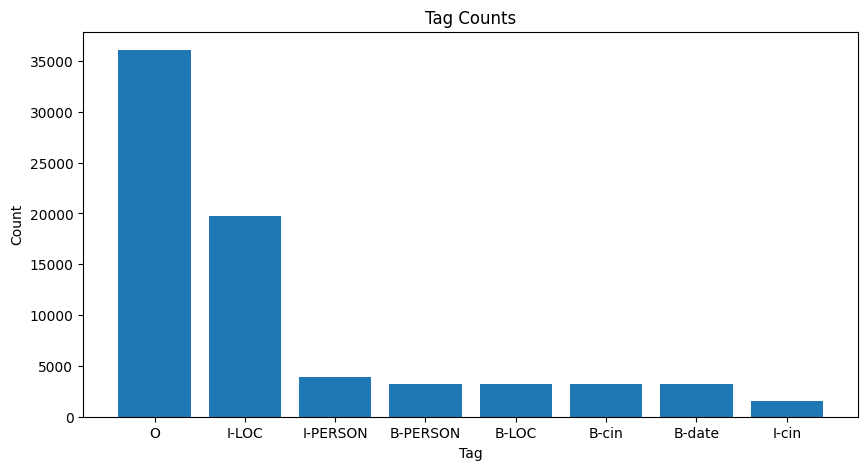

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

tag_counts = train_data['labels'].value_counts()

print(tag_counts)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(tag_counts.index, tag_counts.values)

ax.set_title('Tag Counts')
ax.set_xlabel('Tag')
ax.set_ylabel('Count')

plt.show()

**La même représentation de la précédents avec un autre graph.**

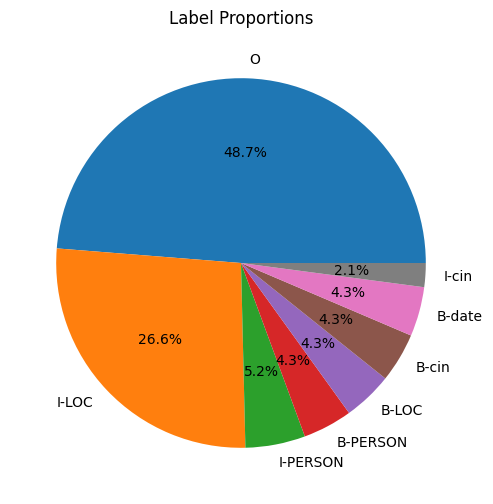

In [ ]:
label_counts = train_data['labels'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')

ax.set_title('Label Proportions')

plt.show()

**Charger les données prepocessed de test et validation**



In [ ]:
test_data = pd.read_csv('Data/test.csv')
validation_data = pd.read_csv('Data/Validation.csv')

In [ ]:
train_data['labels'] = train_data['labels'].str.upper()
test_data['labels'] = test_data['labels'].str.upper()
validation_data['labels'] = validation_data['labels'].str.upper()

In [ ]:
!pip install simpletransformers

**On a utilisé BERT (Bidirectional Encoder Representations from Transformers) qui est une architecture de réseau de neurones pré-entraînée à base de transformateurs qui peut être affinée pour diverses tâches de traitement du langage naturel (NLP), y compris la reconnaissance d'entités nommées (NER).**

In [ ]:
from sklearn.metrics import accuracy_score
from simpletransformers.ner import NERModel,NERArgs

**Extraire la liste des étiquettes (ou labels) uniques dans les données d'entraînement. Cela est nécessaire car l'entraînement du modèle BERT pour la tâche de NER nécessite la définition préalable des étiquettes à prédire.**

Dans le code BERT pour NER, les étiquettes sont extraites à partir des données d'entraînement pour définir la liste des classes que le modèle doit prédire. Cette liste de classes est utilisée pour entraîner le modèle à prédire les étiquettes correctes pour chaque occurrence d'entité nommée dans le texte.

In [ ]:
labels = train_data["labels"].unique().tolist()
labels

['O', 'B-PERSON', 'I-PERSON', 'B-LOC', 'I-LOC', 'B-cin', 'B-date', 'I-cin']

**On enregistre les labels extraits à partir des données d'entraînement dans un fichier texte.**

Lors du chargement d'un modèle enregistré pour la tâche de NER, on peut charger la liste des étiquettes à partir du fichier texte et l'utiliser pour définir la structure de sortie du modèle. Cela permet de s'assurer que le modèle prédit les mêmes étiquettes que celles utilisées lors de l'entraînement.

# NB: "Si on spécifié pas ces étiquettes le model utilise des étiquettes prédifini aléatoirement"


In [ ]:
with open('/content/drive/MyDrive/NamedEntityRecognition/model/labels.txt', 'w') as f:
    for item in labels:
        f.write(item + '\n')

**On définit un certain nombre d'arguments pour entraîner un modèle de NER à l'aide de la bibliothèque simpletransformers** (On a essayé plusieurs arguments, et on a choisit sont qui donnent le bon résultat).

Tout d'abord, on crée une instance de la classe NERArgs() pour stocker les arguments d'entraînement. Ensuite, on définit différents arguments pour l'entraînement du modèle, tels que **le nombre d'époques** d'entraînement num_train_epochs, **le taux d'apprentissage** learning_rate, **la taille des lots d'entraînement** train_batch_size et eval_batch_size, et la **longueur maximale de la séquence d'entrée** max_seq_length.

Ensuite, on définit le répertoire de sortie pour sauvegarder les résultats de l'entraînement output_dir et on spécifie si l'on doit écraser le répertoire de sortie existant overwrite_output_dir.

Enfin, on crée une instance de la classe NERModel en utilisant le modèle BERT pré-entraîné 'bert-base-cased' (**Sensible à la case**), les étiquettes extraites à partir des données d'entraînement labels, et les arguments d'entraînement spécifiés args. Cette instance de modèle peut être utilisée pour entraîner le modèle de NER sur les données d'entraînement et prédire les étiquettes pour de nouvelles données.

In [ ]:
args = NERArgs()
# Training epochs
args.num_train_epochs = 10
# Learning rate
args.learning_rate = 1e-5
# Batch size
args.train_batch_size = 16
args.eval_batch_size = 16
# Maximum sequence length
args.max_seq_length = 128


# Output directory
args.output_dir = 'Output'
# Overwrite the output directory
args.overwrite_output_dir = True

In [ ]:
model = NERModel('bert', 'bert-base-cased',labels=labels,args =args)

**Les données d'entraînement ont deux lignes qui contiennent NA comme B-CIN. Lors du chargement des données avec pandas, NA est considéré comme non disponible, il est donc nécessaire de remplacer la valeur NaN par l'ancienne valeur 'NA' pour conserver l'information pertinente.**

In [ ]:
# Check for missing or invalid values in the DataFrame
print(train_data.isnull().sum())  # Check for missing values
print(train_data.dtypes)          # Check data types of columns

sentence_id    0
words          2
labels         0
dtype: int64
sentence_id     int64
words          object
labels         object
dtype: object


Voici les données "manquants"

In [ ]:
null_rows = train_data['words'].isnull()

# Print the rows with null values for column1
print(train_data[null_rows])

       sentence_id words labels
21377         3882   NaN  B-CIN
54338         9718   NaN  B-CIN


**Remplacer toutes les valeurs manquantes du DataFrame train_data par la chaîne de caractères "NA"**

In [ ]:
train_data.fillna('NA', inplace=True)

In [ ]:
print(train_data.isnull().sum())

sentence_id    0
words          0
labels         0
dtype: int64


**Entraîner un modèle de NER sur des données d'entraînement. Cette méthode prend en entrée les données d'entraînement train_data, qui doivent être un DataFrame contenant les colonnes "words" et "labels", ainsi que les données de validation eval_data, qui sont optionnelles mais permettent de suivre les performances du modèle pendant l'entraînement.**

In [ ]:
model.train_model(train_data, eval_data = validation_data, acc = accuracy_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/801 [00:00<?, ?it/s]

(8010, 0.030652880796055236)

la méthode **eval_model()** est utilisée pour évaluer le modèle model sur les données de test test_data. La méthode renvoie trois valeurs :

**result** : un dictionnaire contenant les résultats de l'évaluation du modèle, comprenant les métriques de performance telles que la précision, le rappel et la F1-score.

**model_outputs** : une liste contenant les sorties du modèle pour chaque exemple dans les données de test.

**preds_list** : une liste contenant les prédictions du modèle pour chaque exemple dans les données de test.

In [ ]:
result, model_outputs, preds_list = model.eval_model(test_data)

**result** contenant les résultats de l'évaluation du modèle sur les données de test. Les résultats comprennent l'erreur d'évaluation (**eval_loss**), la précision (**precision**), le rappel (**recall**), et le score F1 (**f1_score**) pour toutes les classes.

Dans ce cas, les résultats indiquent que le modèle a une précision, un rappel et un score F1 de 1.0 pour toutes les classes, ce qui est excellent et signifie que le modèle a prédit avec précision toutes les étiquettes de l'ensemble de données de test.

Il est important de noter que ces résultats ne donnent qu'une indication de la performance du modèle sur les données de test spécifiques utilisées pour l'évaluation.

In [ ]:
result

{'eval_loss': 1.683800837781746e-05,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0}

**Sauvgarder le modele**

In [ ]:
import torch

torch.save(model.model.state_dict(), "/content/drive/MyDrive/NamedEntityRecognition/model/pytorch_model.bin")

In [ ]:
!pip install simpletransformers

**Le code suivant permet de lire les données nécassaire pour chargé le modele BERT (NER) pour l'utiliser**

In [ ]:
from sklearn.metrics import accuracy_score
from simpletransformers.ner import NERModel,NERArgs

In [ ]:
with open('/content/drive/MyDrive/NamedEntityRecognition/model/labels.txt', 'r') as f:
    labels = []
    line = f.readline()
    while line:
        labels.append(line.strip())
        line = f.readline()

In [ ]:
args = NERArgs()
# Training epochs
args.num_train_epochs = 10
# Learning rate
args.learning_rate = 1e-5
# Batch size
args.train_batch_size = 16
args.eval_batch_size = 16
# Maximum sequence length
args.max_seq_length = 128


# Output directory
args.output_dir = 'Output'
# Overwrite the output directory
args.overwrite_output_dir = True

model = NERModel('bert', 'bert-base-cased',labels=labels,args =args, use_cuda=False)

In [ ]:
import torch

# model.model.load_state_dict(torch.load("/content/drive/MyDrive/NamedEntityRecognition/model/pytorch_model.bin"))

checkpoint = torch.load("/content/drive/MyDrive/NamedEntityRecognition/model/pytorch_model.bin", map_location=torch.device('cpu'))
model.model.load_state_dict(checkpoint)

<All keys matched successfully>

**Tester le modele sur un text réel**

In [ ]:
text = """les parts sociales sont indivisibles a l'égar de la société qui ne reconnait qu'un seul propriétaire pour chacune d'elles.
les copropriétaires indivis sont tenus de désigner l'un d'entre eux pour les représenter auprés de la société ; 4 défaut d'entente, il appartient a la partie la plus diligente de faire désigner par justice un mandataire chargé de les représenter.
TITRE TROISIEME
ADMINISTRATION ET CONTROLE DE LA SOCIETE
ARTICLE 15 : NOMINATION DUREE ET POUVOIRS DE LA GERANCE
La société est administrée par un ou plusieurs gérants, personnes physiques, associés ou non.
La société dera gérée par : 
Mr. KHALID BEN TAGUAR
Nationalité Marocaine
Né le 06.09.1988 à Rabat
Demeurant à Quartier Al Inbiat CP 12000 Temara
Carte de séjour N° KA 214701M
Mr. MOSTAPHA FOUDSI
Nationalité Marocaine
Né le 06.09.1992 à Agadir
Demeurant à 3 AvAhmed Elmansour Addahbi Cité Dakhla CP 80000 Agadir
CIN SY137932"""

In [ ]:
# split the string into individual lines
lines = text.splitlines()
predictions = []
# print each line
for line in lines:
    prediction, model_output = model.predict([line])
    predictions.append(prediction)

**Les résultats obtenus contient quelques prediction fausses donc on va faire un post-traitement sur ces résultats pour obtenir les résultats souhaité**

In [ ]:
predictions

[[[{'les': 'O'},
   {'parts': 'O'},
   {'sociales': 'O'},
   {'sont': 'O'},
   {'indivisibles': 'O'},
   {'a': 'O'},
   {"l'égar": 'O'},
   {'de': 'O'},
   {'la': 'O'},
   {'société': 'O'},
   {'qui': 'O'},
   {'ne': 'O'},
   {'reconnait': 'O'},
   {"qu'un": 'O'},
   {'seul': 'O'},
   {'propriétaire': 'O'},
   {'pour': 'O'},
   {'chacune': 'O'},
   {"d'elles.": 'O'}]],
 [[{'les': 'O'},
   {'copropriétaires': 'O'},
   {'indivis': 'O'},
   {'sont': 'O'},
   {'tenus': 'O'},
   {'de': 'O'},
   {'désigner': 'O'},
   {"l'un": 'O'},
   {"d'entre": 'O'},
   {'eux': 'O'},
   {'pour': 'O'},
   {'les': 'O'},
   {'représenter': 'O'},
   {'auprés': 'O'},
   {'de': 'O'},
   {'la': 'O'},
   {'société': 'O'},
   {';': 'O'},
   {'4': 'O'},
   {'défaut': 'O'},
   {"d'entente,": 'O'},
   {'il': 'O'},
   {'appartient': 'O'},
   {'a': 'O'},
   {'la': 'O'},
   {'partie': 'O'},
   {'la': 'O'},
   {'plus': 'O'},
   {'diligente': 'O'},
   {'de': 'O'},
   {'faire': 'O'},
   {'désigner': 'O'},
   {'par': 'O'},
 

**Le post traitement est réalisé a la base d'un logique.
Concernant Les Personnes: I-PERSON doit être aprés B-PERSON
La même chose pour I-LOC et B-LOC**

In [ ]:
def isContain(tab, value):
  for item in tab:
    if item == value:
      return True
  return False

In [ ]:
def write(keys):
  for k in keys:
    print(k, end = " ")
  print("")

for pred in predictions:
  values = []
  keys = []
  for el in pred[0]:
    key = list(el.keys())[0]
    value = list(el.values())[0]
    if value == 'O':
      continue
    values.append(value)
    keys.append(key)
  if isContain(values, "B-PERSON") and isContain(values, "I-PERSON") and values[0] == 'B-PERSON':
    print("\n")
    write(keys)
  if isContain(values, "B-LOC") and isContain(values, "I-LOC") and values[0] == 'B-LOC':
    write(keys)
  if len(values) == 1 and values[0] == 'B-date':
    write(keys)
  if (isContain(values, 'B-cin') and isContain(values, 'I-cin')) or (isContain(values, 'B-cin')):
    write(keys)



KHALID BEN TAGUAR 
06.09.1988 
Quartier Al Inbiat CP 12000 Temara 
KA 214701M 


MOSTAPHA FOUDSI 
06.09.1992 
3 AvAhmed Elmansour Addahbi Cité Dakhla CP 80000 Agadir 
SY137932 
